In [4]:
# Importing Required Libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [5]:
# Path to input dataset directory
dataset_path = '/kaggle/input/new-wc-dataset/Dataset_Weed_Crop'

# Define constants
image_size = (128, 128)
num_classes = 2  # Crop and Weed

# Create empty lists to store data
data = []
labels = []

# Load and preprocess the dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    class_label = 0 if class_name == 'Crop' else 1  # Assign labels (0 for Crop, 1 for Weed)

    for image_filename in os.listdir(class_path):
        image_path = os.path.join(class_path, image_filename)
        image = load_img(image_path, target_size=image_size)
        image = img_to_array(image)
        image = image / 255.0  # Rescale pixel values to [0, 1]

        data.append(image)
        labels.append(class_label)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [7]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
# Print the shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4200, 128, 128, 3), y_train shape: (4200, 2)
X_val shape: (900, 128, 128, 3), y_val shape: (900, 2)
X_test shape: (900, 128, 128, 3), y_test shape: (900, 2)


In [9]:
# Data Augmentation
# Creating an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # You can adjust the rotation range as needed
    width_shift_range=0.2,  # You can adjust the shift range as needed
    height_shift_range=0.2,
    fill_mode='nearest'  # Filling mode for pixels outside the boundaries
)

# Fit the generator on the training data
train_datagen.fit(X_train)

# Creating data generators for training and validation
batch_size = 32  # You can adjust the batch size as needed
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = ImageDataGenerator(rescale=1./255).flow(X_val, y_val, batch_size=batch_size)


In [10]:
# Loading the InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add more units or layers as needed
predictions = Dense(num_classes, activation='softmax')(x)  # 'num_classes' is 2 for Crop and Weed

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 [==============================] - 0s 0us/step


In [11]:
# Compile the model with binary cross-entropy loss and accuracy
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# creating custom metrics for precision and recall
precision = Precision()
recall = Recall()

# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalization[0][0

In [13]:
# Define hyperparameters for training
epochs = 100  # You can adjust the number of epochs as needed
batch_size = 32  # You can adjust the batch size as needed

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)



Epoch 1/100
131/131 [==============================] - 18s 135ms/step - loss: 0.0387 - accuracy: 0.9870 - val_loss: 0.0310 - val_accuracy: 0.9933
Epoch 2/100
131/131 [==============================] - 17s 130ms/step - loss: 0.0270 - accuracy: 0.9906 - val_loss: 0.1648 - val_accuracy: 0.9375
Epoch 3/100
131/131 [==============================] - 17s 127ms/step - loss: 0.0381 - accuracy: 0.9863 - val_loss: 0.1027 - val_accuracy: 0.9609
Epoch 4/100
131/131 [==============================] - 16s 125ms/step - loss: 0.0505 - accuracy: 0.9820 - val_loss: 0.1349 - val_accuracy: 0.9420
Epoch 5/100
131/131 [==============================] - 16s 126ms/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.1196 - val_accuracy: 0.9475
Epoch 6/100
131/131 [==============================] - 17s 127ms/step - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.0208 - val_accuracy: 0.9933
Epoch 7/100
131/131 [==============================] - 17s 131ms/step - loss: 0.0286 - accuracy: 0.9899 - val_loss: 0.0379 -

In [14]:
# Create a data generator for the test set
test_generator = ImageDataGenerator(rescale=1./255).flow(X_test, y_test, batch_size=1, shuffle=False)

# Get predictions from the model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the classification report
report = classification_report(y_true, y_pred_classes, target_names=['Crop', 'Weed'])

print(report)


900/900 [==============================] - 9s 8ms/step
              precision    recall  f1-score   support

        Crop       0.99      1.00      1.00       440
        Weed       1.00      0.99      1.00       460

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



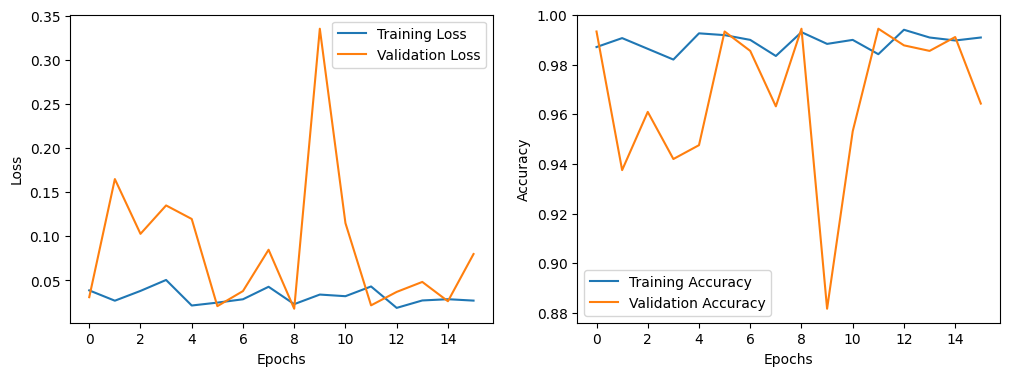

In [15]:
#Visualize Training and Validation Curves
# Extract training history from the history object
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

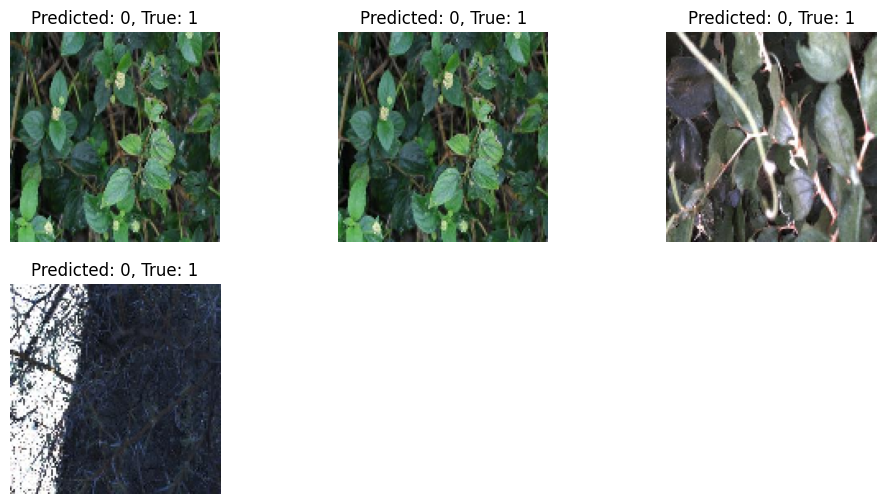

In [16]:
#Analyze Misclassified Images
import random

misclassified_images = []

for i in range(len(y_true)):
    if y_pred_classes[i] != y_true[i]:
        misclassified_images.append((X_test[i], y_pred_classes[i], y_true[i]))

# Randomly select and display some misclassified images
plt.figure(figsize=(12, 6))
num_displayed = min(6, len(misclassified_images))
for i in range(num_displayed):
    index = random.randint(0, len(misclassified_images) - 1)
    image, predicted_class, true_class = misclassified_images[index]
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, True: {true_class}')
    plt.axis('off')

plt.show()


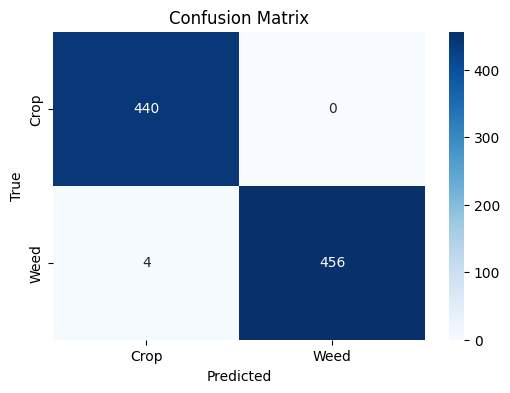

In [17]:
# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
labels = ['Crop', 'Weed']
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**FOR REAL TIME IDENTIFICATION**

In [ ]:
from keras.models import load_model

# Specify the path where you want to save the model
model_save_path = 'WC_CNN_(InceptionV3)/your_model.h5'

# Save the model to the specified path
model.save(model_save_path)

# Optionally, you can also save the model's architecture and weights separately
model_json = model.to_json()
with open('WC_CNN_(InceptionV3)/model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('WC_CNN_(InceptionV3)/model_weights.h5')


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from keras.preprocessing import image

# Load the trained model
from keras.models import load_model

# Specify the path to your trained model
model_path = '/content/WC_CNN_(InceptionV3)/your_model.h5'
model = load_model(model_path)

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/Datasets/Dataset_Weed_Crop/Weed/20160928-140314-0.jpg'

# Specify the target size (the same as what the model was trained on)
target_size = (128, 128)

# Load and preprocess the input image
input_image = image.load_img(input_image_path, target_size=target_size)
input_image = image.img_to_array(input_image)
input_image = np.expand_dims(input_image, axis=0)
input_image = input_image / 255.0  # Rescale pixel values to [0, 1]

# Get the model's prediction for the input image
result = model.predict(input_image)

# Define class labels (Crop and Weed)
class_labels = ['Crop', 'Weed']

# Determine the predicted class
predicted_class = class_labels[np.argmax(result)]

# Load the input image for visualization
input_image = cv2.imread(input_image_path)

# Get the shape of the input image
image_height, image_width, _ = input_image.shape

# Draw a bounding box around the detected weed plant
if predicted_class == 'Weed':
    # Bounding box color (in BGR format, green color)
    color = (0, 255, 0)

    # Coordinates for the bounding box (you may need to adjust these based on your model's input size)
    top_left = (50, 50)  # Adjust the coordinates as needed
    bottom_right = (200, 200)  # Adjust the coordinates as needed

    # Draw the bounding box
    cv2.rectangle(input_image, top_left, bottom_right, color, thickness=2)

# Display the input image with the bounding box
cv2_imshow(input_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
